Hello VRV Team!!

Thank you for Giving me Opportunity to Showcase My Skills in Python. I have Successfully Sompleted the Task Provide to me on to Read The Log Files and Parse the Useful Information from it, i have also made it easy to Identify the Data more clearly by using Data Visualiation Technique.


Requests Per IP (Descending Order):
203.0.113.5     8          Unknown Location
198.51.100.23   8          Unknown Location
192.168.1.1     7          Unknown Location
10.0.0.2        6          Unknown Location
192.168.1.100   5          Unknown Location

Most Accessed Endpoint:
/login (Accessed 13 times)

Suspicious Activity Detected:
IP Address      Failed Login Attempts
203.0.113.5     8                    Unknown Location

Hourly Request Analysis:
2024-12-03 10: 34 requests

Analysis results saved to 'log_analysis_results.csv'.

Generating visualizations...


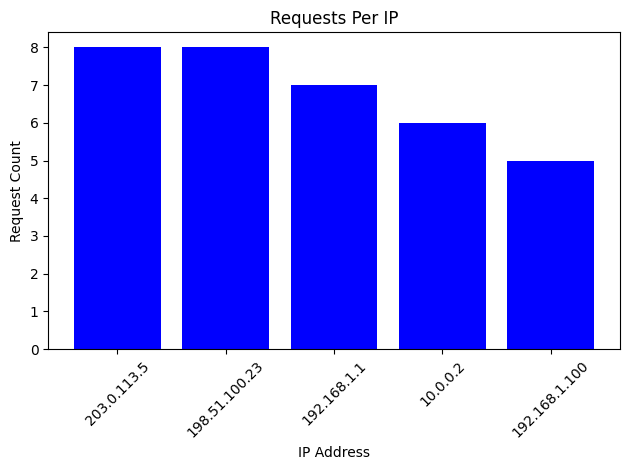

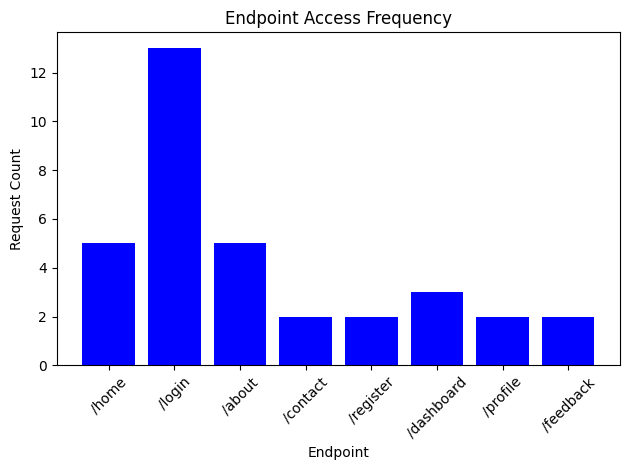

In [ ]:
import re                                       # Used for regular expressions to parse log file lines.
from collections import Counter, defaultdict    # Provides tools for counting and organizing data.
from datetime import datetime                   # For Handling timestamps in the log file.
import csv                                      # used to save results in csv format
from geopy.geocoders import Nominatim           # GeoLocates IP Address to determine aproximate location
import matplotlib.pyplot as plt                 # Used for Data Visualization
from colorama import Fore, Style                # add colored Output ot Terminal Logs


def parse_log_file(file_path):                  # Parse the log file and extract relevant details.
   
    ip_requests = Counter()                     # Count the No. of Requests and action performed for specific task 
    endpoint_requests = Counter()
    failed_logins = Counter()
    timestamps = []

    log_pattern = r'(?P<ip>\b(?:[0-9]{1,3}\.){3}[0-9]{1,3}\b).*"(?P<method>[A-Z]+) (?P<endpoint>\S+) HTTP/\d\.\d" (?P<status>\d+).*'    # Regular expressions for parsing log lines
    failure_pattern = r'Invalid credentials'

    with open(file_path, 'r') as file:                  # Open File in Read Mode
        for line in file:                               # Matching Log Data with Regular Expressions and extract data using Named Groups
            match = re.search(log_pattern, line)
            if match:
                ip = match.group('ip')
                endpoint = match.group('endpoint')
                status = int(match.group('status'))
                timestamp_match = re.search(r'\[(.*?)\]', line)

                ip_requests[ip] += 1                   # Count requests per IP and endpoint
                endpoint_requests[endpoint] += 1

                if timestamp_match:                    
                    timestamps.append(datetime.strptime(timestamp_match.group(1), "%d/%b/%Y:%H:%M:%S %z"))  # Parsed timestamp in datetime object

                if status == 401 or re.search(failure_pattern, line):               # Count failed login attempts
                    failed_logins[ip] += 1

    return ip_requests, endpoint_requests, failed_logins, timestamps                # Returns the result 


def detect_suspicious_activity(failed_logins, threshold=10):                        # In this Function we input the Threshold from User according to that if value is greater than threshold activity is called Suspicious.  
    """Detect IPs with suspicious activity."""
    return {ip: count for ip, count in failed_logins.items() if count > threshold}  


def geolocate_ips(ip_requests):                                                     # Geolocate IP addresses using the Geopy library.
    geolocator = Nominatim(user_agent="log_analysis_script")
    ip_locations = {}

    for ip in ip_requests.keys():
        try:
            location = geolocator.geocode(ip)
            if location:
                ip_locations[ip] = location.address
            else:
                ip_locations[ip] = "Unknown Location"
        except Exception:
            ip_locations[ip] = "Unknown Location"

    return ip_locations


def plot_requests(data, title, xlabel, ylabel):                                     # Visualize data as a bar chart.
    plt.bar(data.keys(), data.values(), color='blue')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


def analyze_timestamps(timestamps):                                                 # Analyze request patterns over time.
    hourly_activity = Counter([timestamp.strftime('%Y-%m-%d %H') for timestamp in timestamps])
    return hourly_activity


# Save the analysis results to a CSV file
def save_to_csv(ip_requests, most_accessed_endpoint, suspicious_activities, hourly_activity, output_file="log_analysis_results.csv"):
    
    with open(output_file, mode='w', newline='') as csvfile:
        writer = csv.writer(csvfile)


        writer.writerow(["Requests per IP"])                                # Write requests per IP
        writer.writerow(["IP Address", "Request Count"])
        for ip, count in ip_requests.items():
            writer.writerow([ip, count])

        writer.writerow([]) 
        
        writer.writerow(["Most Accessed Endpoint"])                         # Write most accessed endpoint
        writer.writerow(["Endpoint", "Access Count"])
        writer.writerow([most_accessed_endpoint[0], most_accessed_endpoint[1]])

        writer.writerow([])                                                
 
        writer.writerow(["Suspicious Activity"])                            # Write suspicious activity
        writer.writerow(["IP Address", "Failed Login Count"])
        for ip, count in suspicious_activities.items():
            writer.writerow([ip, count])

        writer.writerow([])  

        writer.writerow(["Hourly Activity"])                                # Write hourly activity
        writer.writerow(["Hour", "Request Count"])
        for hour, count in hourly_activity.items():
            writer.writerow([hour, count])

def main():
    log_file = "sample.log"  

    ip_requests, endpoint_requests, failed_logins, timestamps = parse_log_file(log_file)  # Parse the log file

    most_accessed_endpoint = endpoint_requests.most_common(1)[0]  # Most accessed endpoint
    threshold = int(input("Enter the threshold for detecting suspicious activity (default: 10): ") or 10)

    suspicious_activities = detect_suspicious_activity(failed_logins, threshold)
    hourly_activity = analyze_timestamps(timestamps)

    ip_locations = geolocate_ips(ip_requests)  # Geolocate IPs

    
    sorted_ip_requests = dict(sorted(ip_requests.items(), key=lambda x: x[1], reverse=True))        # Sort IP requests 

    print(Fore.GREEN + "\nRequests Per IP (Descending Order):" + Style.RESET_ALL)  # Sorted Requests Per IP
    for ip, count in sorted_ip_requests.items():
        location = ip_locations.get(ip, "Unknown Location")
        print(f"{ip:<15} {count:<10} {location}")

    print(Fore.BLUE + "\nMost Accessed Endpoint:" + Style.RESET_ALL)                # Most Accessed Endpoint in Blue
    print(f"{most_accessed_endpoint[0]} (Accessed {most_accessed_endpoint[1]} times)")

    print(Fore.RED + "\nSuspicious Activity Detected:" + Style.RESET_ALL)           # Suspicious Activity in Red
    print(f"{'IP Address':<15} {'Failed Login Attempts':<20}")
    for ip, count in sorted(suspicious_activities.items(), key=lambda x: x[1], reverse=True):  # Sort by Failed Attempts
        location = ip_locations.get(ip, "Unknown Location")
        print(f"{ip:<15} {count:<20} {location}")

    print(Fore.YELLOW + "\nHourly Request Analysis:" + Style.RESET_ALL)             # Hourly Request Analysis in Yellow
    for hour, count in hourly_activity.items():
        print(f"{hour}: {count} requests")

    save_to_csv(ip_requests, most_accessed_endpoint, suspicious_activities, hourly_activity)
    print(Fore.CYAN + "\nAnalysis results saved to 'log_analysis_results.csv'." + Style.RESET_ALL)


    print(Fore.MAGENTA + "\nGenerating visualizations..." + Style.RESET_ALL)                # Visualizing the Results
    plot_requests(sorted_ip_requests, "Requests Per IP", "IP Address", "Request Count")
    plot_requests(endpoint_requests, "Endpoint Access Frequency", "Endpoint", "Request Count")

if __name__ == "__main__":
    main()
